# Authors - Interest as Machine Learning

In [1]:
from __future__ import division
from __future__ import print_function
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
import os
os.getcwd()
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import csv
from collections import Counter
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")


import random
from PIL import Image
from os import path
from nltk.corpus import stopwords
from scipy.misc import imread
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from wordcloud import WordCloud, STOPWORDS

import mysql.connector
from mysql.connector import errorcode
from mysql.connector import Error

import plotly
import networkx as nx
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='raunakm90', api_key='qh9wd16d6g')

import plot_network
import plotly.plotly as py
from plotly.graph_objs import *
#sns.set_context("poster")

from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from collections import Counter
from operator import itemgetter

C:\Users\Raunak Mundada\Anaconda2\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



In [2]:
import mysql_setup
query_list,field_names = mysql_setup.query_with_fetchmany("SELECT * FROM Author")
Author = mysql_setup.make_frame(query_list,field_names)

In [3]:
query_list,field_names = mysql_setup.query_with_fetchmany("SELECT * FROM Publishing_Detail")
Publishing_Detail = mysql_setup.make_frame(query_list,field_names)

## Subset dataset that have the defined keyword in Author Interests

In [4]:
keyword = 'machine learning'
df_ml = pd.DataFrame()
for index,row in Author.iterrows():
    a_interests  = (row['Author_Interests'])
    if keyword in a_interests.lower():
        df_ml =  df_ml.append(row,ignore_index=True)

Dictionary with key value pair as the author ID and author name

In [5]:
a_dict = df_ml.set_index('Author_Id')['Author_Name'].to_dict()
a_dict

{u'1DS8DjgAAAAJ': u'Jonathan Hays',
 u'5Iqe53IAAAAJ': u'Daphne Koller',
 u'6yx_xmcAAAAJ': u'Kay H. Brodersen',
 u'DxoenfgAAAAJ': u'Michael Collins',
 u'JicYPdAAAAAJ': u'Geoffrey Hinton',
 u'P6krKIkAAAAJ': u'David Lopez Mateos',
 u'R94cBVgAAAAJ': u'Sayan Mukherjee',
 u'U_IVY50AAAAJ': u'Corinna Cortes',
 u'WLN3QrAAAAAJ': u'Yann LeCun',
 u'ZpG_cJwAAAAJ': u'Robert Tibshirani',
 u'lMkTx0EAAAAJ': u'Jason Weston',
 u'ofMZr0IAAAAJ': u'Cheng Soon Ong',
 u'paTAXiIAAAAJ': u'Kalyanmoy Deb',
 u'vtegaJgAAAAJ': u'vapnik',
 u'yxUduqMAAAAJ': u'Michael I. Jordan',
 u'zQWbCzYAAAAJ': u'Joachim M. Buhmann'}

Get the corresponding publication details

In [6]:
#Get the publications of the required authors
a_id = a_dict.keys()
DB_NAME = 'NLP_Project'
in_p=', '.join(list(map(lambda x: '%s', a_id)))
sql = ("SELECT * FROM publishing_Detail WHERE Author_Id in (%s)")
sql = sql % in_p
query_list = list()
cnx = mysql.connector.connect(user='root',password = "raunak")
cursor = cnx.cursor()
cnx.database = DB_NAME
cursor.execute(sql,a_id)

for row in iter(cursor):
        query_list.append(row)
        num_fields = len(cursor.description)
        field_names = [i[0] for i in cursor.description]
        field_names
        
cursor.close()
cnx.close()
ml_pubs = mysql_setup.make_frame(query_list,field_names)

## Connection between the authors

In [7]:
import string
exclude = set(string.punctuation)

def handle_strings(x):
    """
    Helper function to make string all lower and remove punctuation.
    
    x: any string
    """
    x = x.lower()
    x = ''.join(ch for ch in x if ch not in exclude)
    return x

ind = Author.Author_Cited_By.sort_values(ascending = False).index
# Select top 4 indices
top_Authors = Author[Author.index.isin(ind)]
a_dict = top_Authors.set_index('Author_Id')['Author_Name'].to_dict()

adj_mat = pd.DataFrame(0.0, index=a_dict.values(), columns=a_dict.values())
am = adj_mat.copy()
for key in a_dict.iterkeys():
    x = ml_pubs[ml_pubs['Author_Id'] == key]
    n = len(x)
    a = a_dict[key]
    Pub_Authors = x['Pub_Authors'].tolist()
    Pub_Authors = ",".join(unicode(i) for i in Pub_Authors if not i.isdigit())
    Pub_Authors = Pub_Authors.split(",")
    fname = open("./List_ml_"+a,"wb")
    fname.writelines(Pub_Authors)
    fname.close()
    if n!=0:
        for value in a_dict.itervalues():
            if value!=a:
                #m = [s for s in Pub_Authors if handle_strings(value) in handle_strings(s)]
                m = [s for s in Pub_Authors if 
                     fuzz.partial_ratio(handle_strings(value),handle_strings(s))>85]
                adj_mat[a][value] = len(m)/n
                am[a][value] = len(m)

#pd.DataFrame.to_clipboard(adj_mat)


Gr=nx.from_numpy_matrix(adj_mat.values)
position=nx.circular_layout(Gr)
labels = list(adj_mat.columns.values)

traceE=plot_network.scatter_edges(Gr, position)
traceN=plot_network.scatter_nodes(Gr,position,labels = labels,size_flag=1)

fig = Figure(data=Data([traceE, traceN]),
             layout=Layout(
                title='<br>Network Graph - Author Connections with ML',
                titlefont=dict(size=18),
                showlegend=False, 
                width=750,
                height=750,
                margin=dict(b=20,l=5,r=5,t=40),
                hovermode='closest',
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))

#py.iplot(fig, filename='Top Authors')

iplot(fig)

Hover over the graph to see details regarding the nodes.
Vapnik is the highly connected individual (based on the sample) with 6 connections. The scale of the colour is defined according to the number of connections of each author.

### Visualize the adjacency matrix

In [8]:
annotations = []
row_labels = adj_mat.columns
col_labels = adj_mat.columns
for n, row in enumerate(adj_mat.values):
    for m, val in enumerate(row):
        val = adj_mat.values[n][m].round(2)
        annotations.append(
            dict(
                text=str(val),
                x=row_labels[m], y=col_labels[n],
                xref='Authors', yref='Authors',
                font=dict(color='white' if val > 20 else 'black'),
                showarrow=False)
            )

colorscale = [[0, '#3D9970'], [1, '#001f3f']]  # custom colorscale
trace = Heatmap(x=row_labels, y=col_labels, z=adj_mat.values.round(2), colorscale = colorscale,showscale=False)

fig = Figure(data=[trace])
fig['layout'].update(
    title="Connection Strength",
    annotations=annotations,
    xaxis=dict(ticks=''),
    # ticksuffix is a workaround to add a bit of padding
    yaxis=dict(ticks='', ticksuffix='  '),
    width=1000,
    height=1000,
    autosize=False
)
py.iplot(fig, filename='Connection Strength', height=1000)

The strength of the connection is defined as number of times an author cites another divided by his toal publications

## Which journals are popular among these authors?

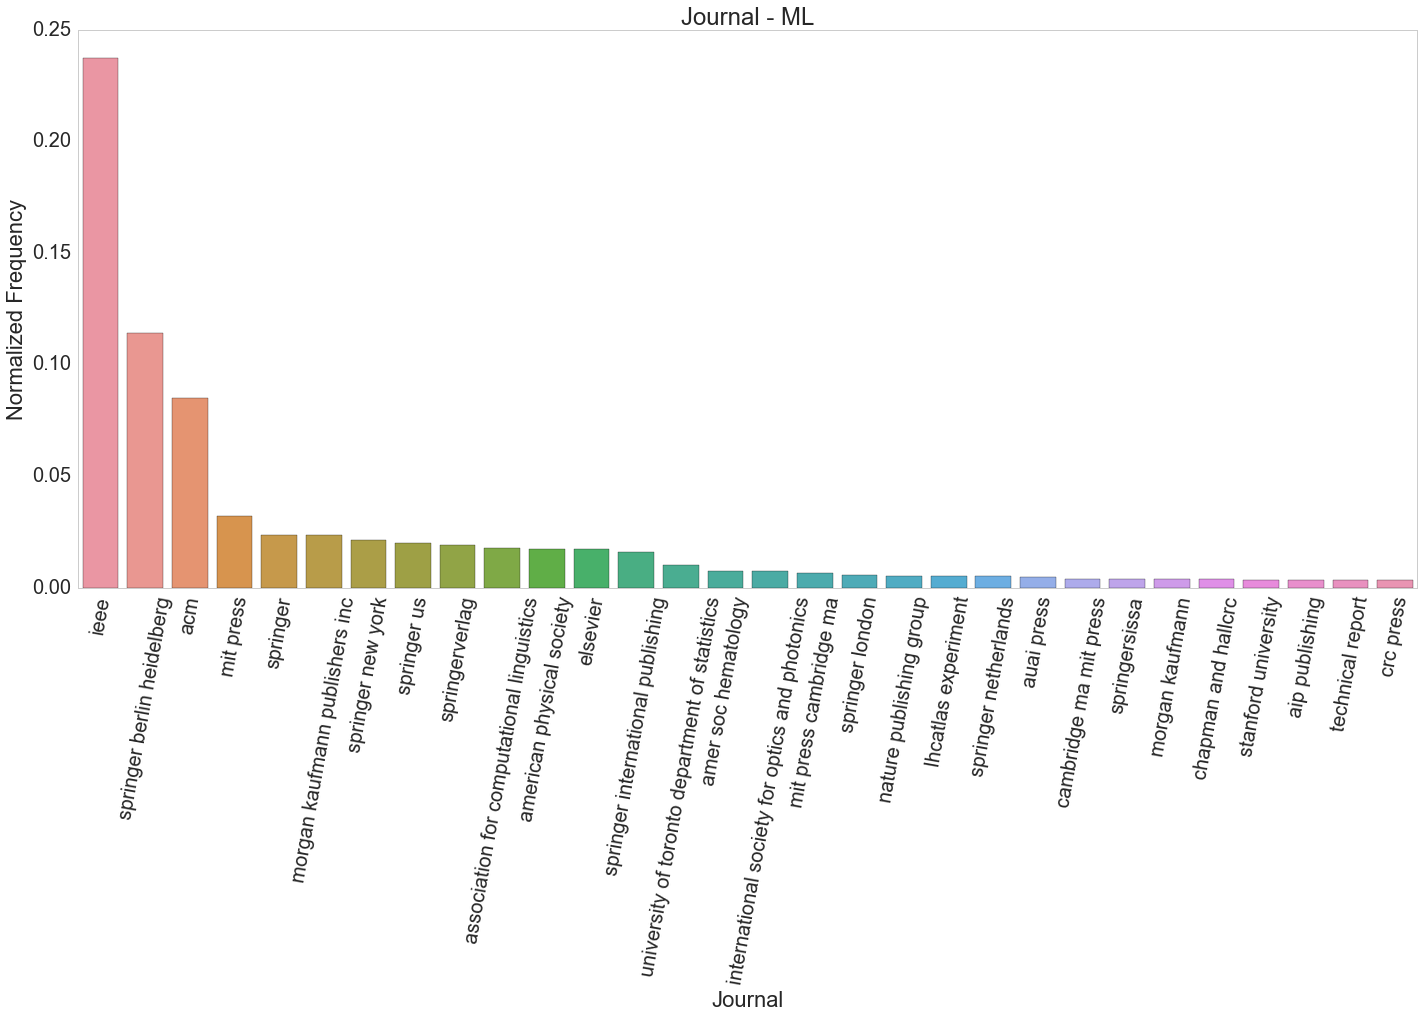

In [9]:
import string
exclude = set(string.punctuation)

def handle_strings(x):
    """
    Helper function to make string all lower and remove punctuation.
    
    x: any string
    """
    x = x.lower()
    x = ''.join(ch for ch in x if ch not in exclude)
    return x

def sort_dict(d,reverse=False):
    return sorted(d.iteritems(), key=itemgetter(1), reverse=True)

def to_lower(x):
    return (x.lower())

x = pd.DataFrame()
for index,row in ml_pubs.iterrows():
    if (row['Pub_Journal'] != 'NULL' or row['Pub_Publisher'] != 'NULL'):
        if row['Pub_Journal'] == 'NULL':
            row['Pub_Journal'] = row['Pub_Publisher']
            x = x.append(row,ignore_index=True)
journal_ml = x['Pub_Journal'].tolist()


journal_ml = map(to_lower,journal_ml) 
journal_ml = map(handle_strings,journal_ml)
journal_ml_count = Counter(journal_ml)
journal_ml_count = sort_dict(journal_ml_count)
journal_ml_count = pd.DataFrame(journal_ml_count,columns=['Journal','Count'])
journal_ml_count = journal_ml_count[journal_ml_count['Count']>5]
journal_ml_count['Count'] = journal_ml_count.Count/len(journal_ml)
sns.set(font_scale = 2)
sns.set_context({"figure.figsize": (24, 10)})
sns.set_style("whitegrid")
labels = journal_ml_count.Journal
g = sns.barplot(x = "Journal", y = "Count", data = journal_ml_count)
g.set_xticklabels(labels,rotation = 80)
plt.title("Journal - ML")
plt.xlabel('Journal')
plt.ylabel('Normalized Frequency')
g.axes.grid('off')